Class distribution: Class
0    384
1    149
Name: count, dtype: int64

🚀 Training: Logistic Regression
✅ Accuracy: 0.7383
📊 Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.74      0.99      0.84        77
   High Risk       0.75      0.10      0.18        30

    accuracy                           0.74       107
   macro avg       0.74      0.54      0.51       107
weighted avg       0.74      0.74      0.66       107


🚀 Training: Random Forest
✅ Accuracy: 0.6355
📊 Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.73      0.79      0.76        77
   High Risk       0.30      0.23      0.26        30

    accuracy                           0.64       107
   macro avg       0.52      0.51      0.51       107
weighted avg       0.61      0.64      0.62       107


🚀 Training: XGBoost


c:\Users\LENOVO\Personalized_Healthcare_Recommendations\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [20:38:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy: 0.6729
📊 Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.73      0.86      0.79        77
   High Risk       0.35      0.20      0.26        30

    accuracy                           0.67       107
   macro avg       0.54      0.53      0.52       107
weighted avg       0.63      0.67      0.64       107



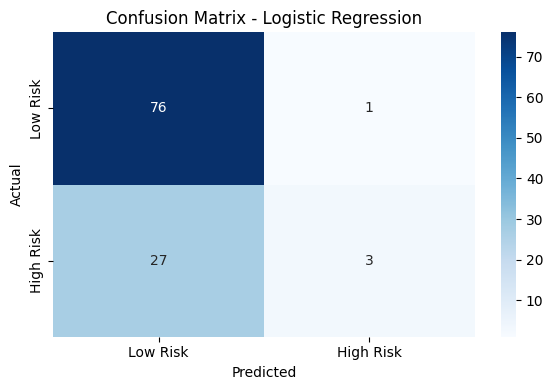


💾 Saving best model: Logistic Regression


['../models/logistic_regression_pipeline.pkl']

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
df = pd.read_csv("../data/cleaned_blood_data.csv")

# Check and print class distribution
print("Class distribution:", df["Class"].value_counts())

# Define manual label mapping (based on your dataset’s meaning)
label_mapping = {0: "Low Risk", 1: "High Risk"}  # Adjust as needed
target_names = [label_mapping[i] for i in sorted(label_mapping)]

# Split features and target
X = df.drop("Class", axis=1)
y = df["Class"]

# Identify column types
categorical_features = X.select_dtypes(include="object").columns.tolist()
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Preprocessing pipelines
num_pipeline = Pipeline([("scaler", StandardScaler())])
cat_pipeline = Pipeline(
    [("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    [
        ("num", num_pipeline, numerical_features),
        ("cat", cat_pipeline, categorical_features),
    ]
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define models
models = {
    "Logistic Regression": Pipeline(
        [
            ("preprocessor", preprocessor),
            ("classifier", LogisticRegression(max_iter=1000, random_state=42)),
        ]
    ),
    "Random Forest": Pipeline(
        [
            ("preprocessor", preprocessor),
            ("classifier", RandomForestClassifier(n_estimators=100, random_state=42)),
        ]
    ),
    "XGBoost": Pipeline(
        [
            ("preprocessor", preprocessor),
            (
                "classifier",
                XGBClassifier(
                    use_label_encoder=False, eval_metric="mlogloss", random_state=42
                ),
            ),
        ]
    ),
}

# Evaluate models
best_model_name = None
best_accuracy = 0
best_predictions = None

for name, model in models.items():
    print(f"\n🚀 Training: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Accuracy: {acc:.4f}")
    print("📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    if acc > best_accuracy:
        best_model_name = name
        best_accuracy = acc
        best_predictions = y_pred


# Confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=target_names,
        yticklabels=target_names,
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


plot_conf_matrix(y_test, best_predictions, f"Confusion Matrix - {best_model_name}")

# Save best model
print(f"\n💾 Saving best model: {best_model_name}")
joblib.dump(
    models[best_model_name],
    f"../models/{best_model_name.lower().replace(' ', '_')}_pipeline.pkl",
)